## Linear SVM

In this notebook you will write code to manually calculate SVM prediction and training via gradient descent on the loss function

In [21]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split


### Load the modified Iris dataset

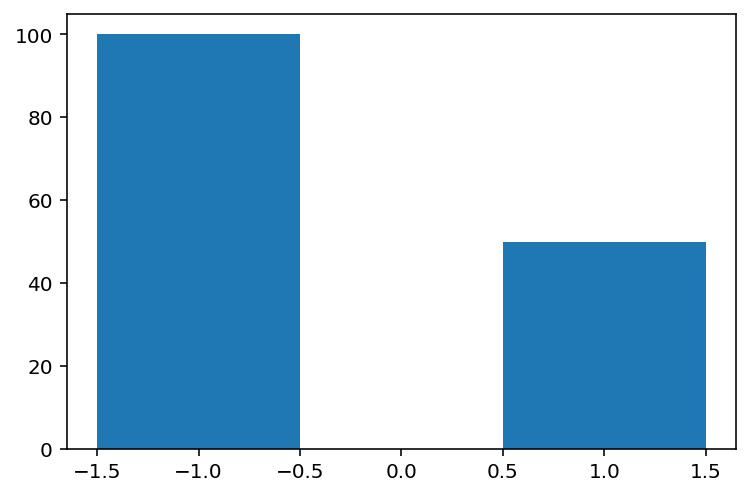

In [22]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

# Here for convenience, we divide the 3 kinds of flowers into 2 groups: 
#     Y = 0 (or False):  Setosa (original value 0) / Versicolor (original value 1)
#     Y = 1 (or True):   Virginica (original value 2)

# Thus we use (iris.target > 1.5) to divide the targets into 2 groups. 
# This line of code will assign:
#    Y[i] = True  (which is equivalent to 1) if iris.target[k]  > 1.5 (Virginica)
#    Y[i] = False (which is equivalent to 0) if iris.target[k] <= 1.5 (Setosa / Versicolor)

Y = (iris.target > 1.5).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
Y[Y==0] = -1

plt.hist(Y,bins=[-1.5,-0.5,0.5,1.5]); # let's see the class distribution, looks like it's mostly Class -1!

# get 100 in training set, 50 in test set. 
# Also let's stratify so that we force the training set to have the right class balance!
# finally we're only going to use variables 1 & 3 for classification 
X_train, X_test, Y_train, Y_test = train_test_split( X[:,[3,1]], Y, test_size=50, 
                                                     stratify=Y, shuffle=True ,random_state=42)

### Visualization

In [23]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    
    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

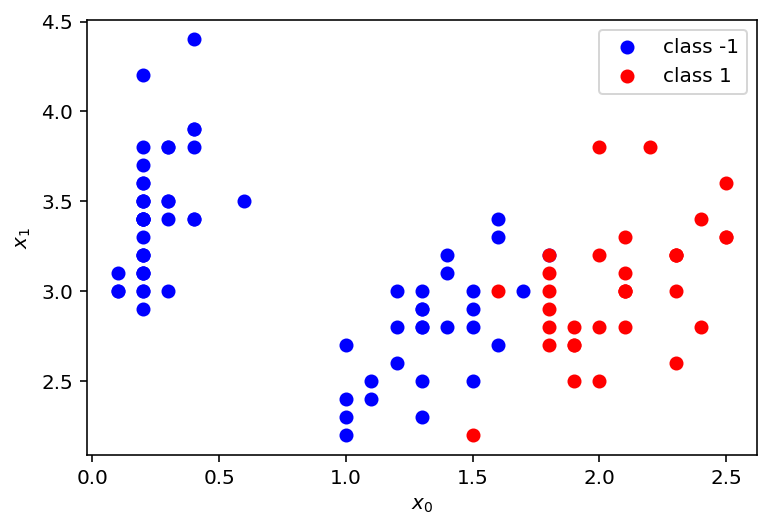

In [24]:
# Visualize training set.
vis(X_train, Y_train)

### Linear SVM Using Gradient Descent

In this problem, we would like to use the gradient descent to calculate the parameters $\mathbf{w},b$ for a linear SVM model.
If we have the loss function $\mathcal{L}(\mathbf{w},b)$, then a typical gradient descent algorithm contains the following steps:

**Step 1**. Initialize the parameters $\mathbf{w}$, $b$.

for i = 1 to #iterations:

- **Step 2**. Compute the partial derivatives $\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial \mathbf{w}}$, $\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b}$.

- **Step 3**. Update the parameters 
$$\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial \mathcal{L}(\mathbf{w}, b)}{\partial \mathbf{w}}, \quad\quad b \leftarrow b - \eta \frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b}$$
where $\eta$ is the learning rate.

Note that in the code, we use `W` and `b` to represent the weight vector $\mathbf{w}$ and bias scalar $b$.

**Hint**: You may refer to HW4 Q6.

In [26]:
# helper function: 1(a != b). It supports scalar, vector and matrix.
def is_not_equal(a, b):
    return np.array(a != b).astype(np.float32)

# helper function: 1(z > 0). It supports scalar, vector and matrix.
def is_positive(z):
    return np.array(z > 0).astype(np.float32)
    
# Rectifier function: (z)_+ = max(0, z). It supports scalar, vector and matrix.
def rectifier(z):
    return np.clip(z, a_min=0, a_max=None)

# The prediction step of a trained linear SVM classifier.
def f_linear_svm(x, W, b):
    # x should be a 2-dimensional vector, 
    # W should be a 2-dimensional vector,
    # b should be a scalar.
    # you should return a scalar which is -1 or 1. 
    return 1 if (np.dot(W,x) + b >= 0) else -1

    
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, W, b):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        e += is_not_equal(yi, f_linear_svm(xi, W, b))
    e = 1.0 * e / n
    return e

In [46]:
# Gradient of L(W, b) with respect to W and b.
def grad_L_W_b(X, Y, W, b, C):
    bold_1 = np.ones_like(Y)
    a = bold_1 - Y * (X@W + b * bold_1)
    grad_W = W - C * (X.T @ (is_positive(a) * Y))
    grad_b = (-1 * C) * np.dot(bold_1, is_positive(a) * Y)
    return grad_W, grad_b

In [50]:
# Loss L(W, b).
def L_W_b(X, Y, W, b, C):
    bold_1 = np.ones_like(Y)
    a = bold_1 - Y * (X@W + b * bold_1)
    return 0.5 * (W.T @ W) + C * (bold_1.T @ rectifier(a))

In [51]:
# Some settings.
learning_rate = 0.00005
iterations    = 10000
losses = []

# Gradient descent algorithm for linear SVM classifier.
# Step 1. Initialize the parameters W, b.
W = np.zeros(2) 
b = 0
C = 1000

for i in range(iterations):
    # Step 2. Compute the partial derivatives.
    grad_W, grad_b = grad_L_W_b(X_train, Y_train, W, b, C) 
    # Step 3. Update the parameters.
    W = W - learning_rate * grad_W
    b = b - learning_rate * grad_b

    # Track the training losses.
    losses.append(L_W_b(X_train, Y_train, W, b, C))

### Visualize the results

Decision boundary: 18.225x0+-4.720x1+-15.850=0


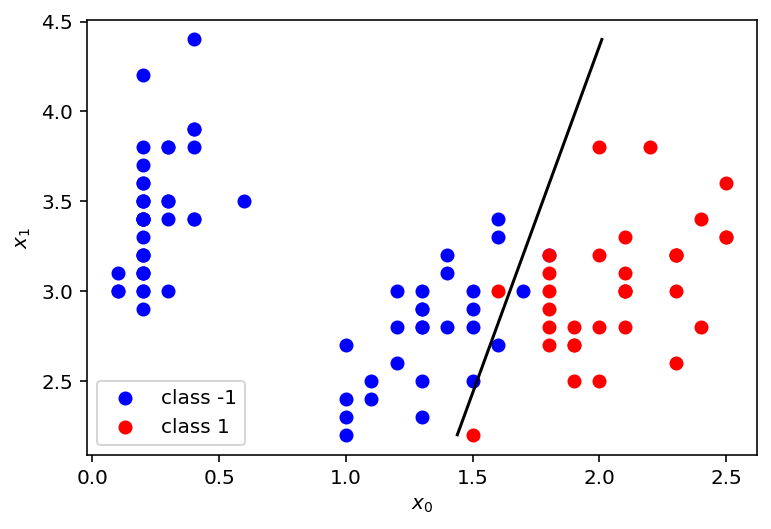

Training error: 0.04


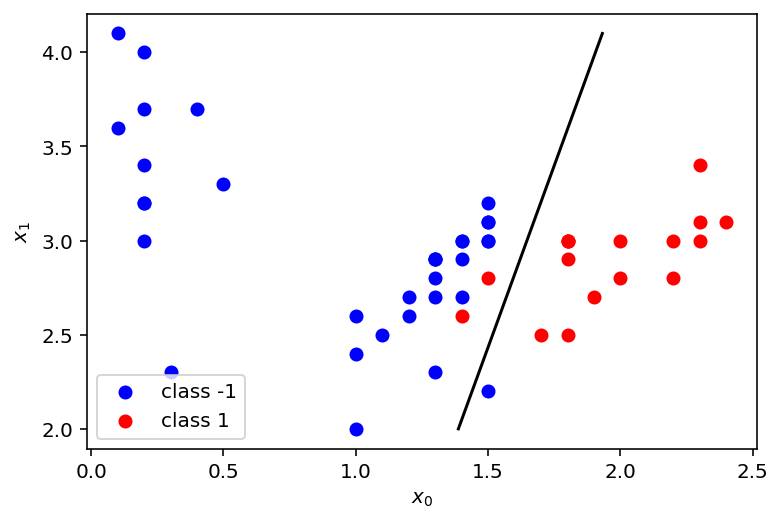

Test error: 0.06


In [52]:
# Show decision boundary, training error and test error.
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0],W[1],b))
vis(X_train, Y_train, W, b)
print('Training error: {}'.format(calc_error(X_train, Y_train, W, b)))
vis(X_test, Y_test, W, b)
print('Test error: {}'.format(calc_error(X_test, Y_test, W, b)))

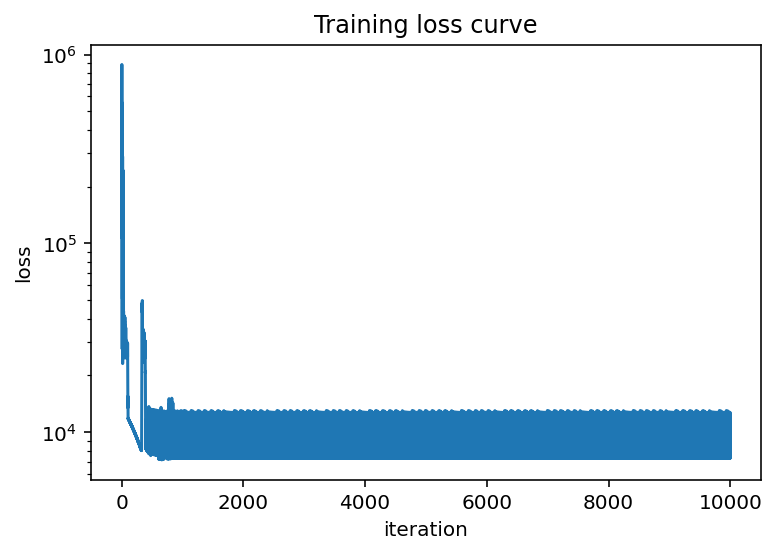

In [53]:
# Plot training loss curve.
plt.title('Training loss curve')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(losses)
plt.yscale('log')
plt.show()